# Implementation of a Dense Neural Networks with multiple layers for Regression problems using numpy (Deep Learning)

## 1. Introduction

Artificial feed forward networks are very good at dealing with highly non linear data representations. With the addition of more layers (deep) higher dimensional complex data can be represented very accurately by the trained network. Hyper parameter tuning (number of layers, number of nodes in each layer) can reduce the overfitting and lead to a network with good variance-bias balance. The neural network implementation used for the binary classification task is used in its entirety except of the Loss function. Since this is a regression problem, Mean Squared Error is used as the Cost function. It is defined as below.

$$ Cost = \frac{1}{2m}\sum_{i=1}^{m}(y_{predicted}^{i}-y^{i})^2 $$

here m is the number of training examples.

Please refer to these two github repos for more details about the implementation of the neural network. The current regression model uses mini batch Stochastic gradient descent algorithm to minmize the cost function and train the weights and biases.

<a href= https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Neural%20Network%20GD_Classification/Dense_neural_network_many_layers.ipynb>1. Neural network for binary classification with Gradient Descent.</a> <p>
<a href = https://github.com/apj2n4/Machine-Learning-from-scratch/blob/master/Neural%20Network%20SGD_Classification/Loan_Default_Binary_Classification.ipynb>2. Neural network for binary classification with mini batch Stochastic Gradient Descent.</a>

<img src="./Dense_Neural_Network.JPG" style="width:850px;height:400px;">

## 2. Exponential Linear Unit

The exponential linear unit or ELU activation function has been added to the deep learning python class. According to literature it has the potential to fit the data and lead to faster convergence. It is shown below,


$$ELU=\begin{Bmatrix}
       x &   x>0 \\
       \alpha.(exp^x-1) & x<0 \\
      \end{Bmatrix}
$$     


Derivative of ELU is as follows,


$$
\frac{d}{dx}ELU = \begin{Bmatrix}
                    1 &   x>0 \\
                    \alpha.exp^x & x<0 \\
                    \end{Bmatrix}
$$                  
                      


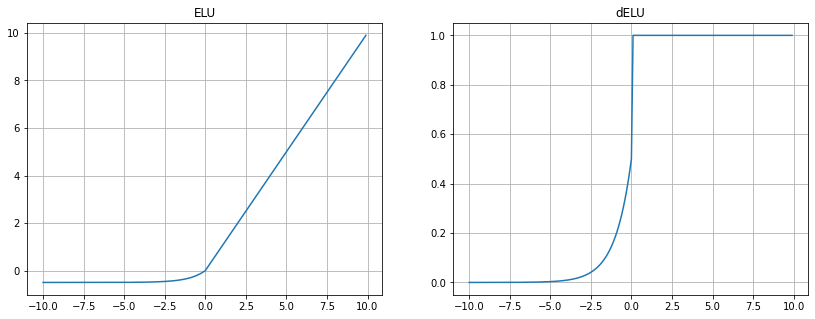

In [1]:
import numpy as np
import pickle
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

def elu(x):
    gamma=0.5
    return np.where(x>=0.0,x,gamma*(np.exp(x)-1))

def delu(x):
    gamma=0.5
    return np.where(x>=0.0,1.0,gamma*np.exp(x))

x_var = np.arange(-10,10,0.1)
fig = plt.figure(figsize=(14,5))
# fig.subplots_adjust(hspace=2, wspace=1)
ax = fig.add_subplot(1, 2, 1)
ax.plot(x_var,elu(x_var))
ax.set_title('ELU')
ax.grid()

ax = fig.add_subplot(1,2,2)
ax.plot(x_var,delu(x_var))
ax.set_title("dELU")
ax.grid()

## 3. Python Class Implementation.

The regression dense neural network implementation is shown below. Mini batch Stochastic gradient descent has been used with MSE as the Cost function. The details are very similar to the previous two implementations for the binary classification task.

In [2]:
class dense_NN_sgd_reg():
    def __init__(self,seed=10):        
        self.nn_struct={}
        self.index = int(0)
        self.W = {}
        self.b = {}
        self.Z = {}
        self.A = {}
        self.dA = {}
        self.dZ = {}
        self.dW = {}
        self.dB = {}
        #self.cost = []
        self.cost_list=np.array([])
        self.random = np.random.RandomState(seed)
    
    ###################Scaler###################
    def scaler_fit(self,X):
        self.X_max = X.max(0)
        self.X_min = X.min(0)
            
    def scaler_transform(self,X):
        return (X-self.X_min)/(self.X_max-self.X_min)
    
    ############################################
    
    #################Activation functions & derivatives###################
    ############Activation Functions############
    def sigmoid(self,x):
        return 1/(1+np.exp(-x))
    
    def RELU(self,x):
        return np.maximum(0,x)
    
    def tanh(self,x):
        return np.tanh(x)
    
    def leakyRELU(self,x):
        return np.maximum(0.1*x,x)
    
    def elu(self,x):
        gamma=0.5
        return np.where(x>=0.0,x,gamma*(np.exp(x)-1))
    
    #############Derivatives#####################
    def dsigmoid(self,X):
        return self.sigmoid(X)*(1-self.sigmoid(X))
    
    def dRELU(self,x):
        return np.where(x>=0.0,1.0,0.0)   
    
    def dtanh(self,X):
        return (1-np.square(np.tanh(X)))
    
    def dleakyRELU(self,x):
        return np.where(x>=0.0,1.0,0.1)
    
    def delu(self,x):
        gamma=0.5
        return np.where(x>=0.0,1.0,gamma*np.exp(x))
    
    ##############################################
    
    def g(self,X,fun=None):
        if fun=="RELU":
            return self.RELU(X)
        if fun=="tanh":
            return self.tanh(X)
        if fun=='sigmoid':
            return self.sigmoid(X)
        if fun=='leakyRELU':
            return self.leakyRELU(X)
        if fun=="elu":
            return self.elu(X)
        return(X)
    
    def g_prime(self,X,fun=None):
        if fun=="RELU":
            return self.dRELU(X)
        if fun=="tanh":
            return self.dtanh(X)
        if fun=='sigmoid':
            return self.dsigmoid(X)
        if fun=='leakyRELU':
            return self.dleakyRELU(X)
        if fun=='elu':
            return self.delu(X)        
        return(1)
    ####################################################################################
    
    ################################Cost Function########################################
    def cost(self,y_true,y_pred):
        m = y_true.shape[1]
        error = (y_pred - y_true)
        return 1/(2*m)*np.dot(error,np.transpose(error))
        #return -np.sum(np.multiply(y_true,np.log(y_pred))+np.multiply((1-y_true),np.log(1-y_pred)))/m
    
    #####################################################################################
           
    def input_data(self,X,y):
        self.scaler_fit(X)
        X_scaled = self.scaler_transform(X)
        self.X = X_scaled
        self.y = y.reshape((1,-1))
        self.m = X_scaled.T.shape[1]
        self.n0 = X_scaled.shape[1]
        

    def add_layer(self,nodes=5,act_fun='RELU'):
        self.index += 1
        add_lay = {self.index:[nodes,act_fun]}
        self.nn_struct.update(add_lay)
        
    def summary(self):
        n_param = 0
        L = max(sorted(self.nn_struct))
        for i in range(1,L+1):
            nodes = self.nn_struct[i][0]
            act_fun = self.nn_struct[i][1]
            print("Layer:",i," Node Count:",nodes," Activation Function:",act_fun)
            if i==1:
                n_param += self.n0*nodes + nodes
            else:
                n_param += self.nn_struct[i-1][0]*nodes + nodes
        print("Total Number of Trainable params:",n_param)
        
    
    ######################## Randomize the weight arrays#######################
    def nn_compile(self):
        self.L = max(sorted(self.nn_struct))
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                W = 0.02*self.random.rand(value[0],self.n0)
                b = np.zeros((value[0],1))
                self.W.update({key:W})
                self.b.update({key:b})
            else:
                W = 0.02*self.random.rand(value[0],self.nn_struct[key-1][0])
                b = np.zeros((value[0],1))
                self.W.update({key:W})
                self.b.update({key:b})
    ###########################################################################
    
    def forward_prop(self,verbose=False):
        L = max(sorted(self.nn_struct))
        ##############Forward Propagation###############
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key],self.X_batch.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],self.A[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            self.Z.update({key:Z})
            self.A.update({key:A})
        ################################################
        
    
    def back_prop(self):
        ############### Total Number of Layers based on Input###########
        L = max(sorted(self.nn_struct))
        ###############Back Propagation #################
        dAL = self.A[L]-self.y_batch
        dZ = dAL*self.g_prime(self.Z[L],fun=self.nn_struct[L][1])
        dW = np.dot(dZ,self.A[L-1].T)/self.m
        dB = np.sum(dZ,axis=1,keepdims=True)/self.m
        dAL_1 =  np.dot(self.W[L].T,dZ)
        
        self.dA.update({L:dAL})
        self.dZ.update({L:dZ})
        self.dW.update({L:dW})
        self.dB.update({L:dB})
        self.dA.update({L-1:dAL_1})
        
        
        for i in range(L-1,0,-1):
            dZ = self.dA[i]*self.g_prime(self.Z[i],fun=self.nn_struct[i][1])
            dW = np.dot(dZ,self.A[i-1].T)/self.m
            dB = np.sum(dZ,axis=1,keepdims=True)/self.m                    
            dAL_1 = np.dot(self.W[i].T,dZ)
            if(i!=1):
                self.dA.update({i-1:dAL_1})
            self.dZ.update({i:dZ})
            self.dW.update({i:dW})
            self.dB.update({i:dB})
         
        for i in range(1,L+1,1):
            self.W[i]=self.W[i]-self.alpha*self.dW[i]
            self.b[i]=self.b[i]-self.alpha*self.dB[i]
    
    def fit(self,alpha=0.01,epochs=100,batch_size=10,call_back=10,verbose=False):
        self.alpha = alpha
        indices = np.arange(self.X.shape[0])
        cb = 0
        for i in range(1,epochs):
            self.random.shuffle(indices)            
            for start_idx in range(0,self.m-batch_size+1,batch_size):
                batch_idx = indices[start_idx:start_idx+batch_size]
                self.X_batch = self.X[batch_idx]
                #### Asssing A0 to X_batch, the zeroth layer##
                self.A.update({0:self.X_batch.T})
                self.y_batch = self.y[:,batch_idx]
                self.forward_prop(verbose)                
                self.back_prop()
            cost = self.cost(self.y,self.forward_predict(self.X))
            self.cost_list = np.append(self.cost_list,cost)
            #i=len(self.cost_list)
            if verbose:
                print("Epoch: ",i,"Binary Cross Entropy Cost: ",cost)
            if np.isnan(self.cost_list[i-1]):
                break
            if i>1:                
                if (self.cost_list[i-2]-self.cost_list[i-1])<0:
                    cb +=1
                if cb > call_back:
                    break
    
    def forward_predict(self,X_new):
        L = max(sorted(self.nn_struct))
        X_scaled = X_new
        m = X_new.shape[0]
        A_dict = {}
        Z_dict = {}
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key], X_scaled.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],A_dict[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            Z_dict.update({key:Z})
            A_dict.update({key:A})
        y_pred = A_dict[L]               
        return y_pred
    
    def predict(self,X_new):
        L = max(sorted(self.nn_struct))
        X_scaled = self.scaler_transform(X_new)
        m = X_new.shape[0]
        A_dict = {}
        Z_dict = {}
        for key,value in sorted(self.nn_struct.items()):
            if(key==1):
                Z = np.dot(self.W[key], X_scaled.T)+self.b[key]
                A = self.g(Z,fun=value[1])
            else:
                Z = np.dot(self.W[key],A_dict[key-1])+self.b[key]
                A = self.g(Z,fun=value[1])
            Z_dict.update({key:Z})
            A_dict.update({key:A})
        y_pred = A_dict[L].reshape(-1)
        #y_class = np.zeros(m)
        #y_class[y_pred>0.5]=1
        
        return y_pred

## 4. Boston Housing Prices dataset EDA

Scikit-learn library has many in-built datasets and boston dataset is one of them. The performance of the feed forward neural network implementations is evaluated on the Boston dataset and compared with algorithms from scikit learn and tensorflow libraries. More information about the dataset can be learned from the sklearn libraris and also looking at description which is part of the dataset object. The dataset has the following features 
        - CRIM     per capita crime rate by town
        - ZN       proportion of residential land zoned for lots over 25,000 sq.ft.
        - INDUS    proportion of non-retail business acres per town
        - CHAS     Charles River dummy variable (= 1 if tract bounds river; 0 otherwise)
        - NOX      nitric oxides concentration (parts per 10 million)
        - RM       average number of rooms per dwelling
        - AGE      proportion of owner-occupied units built prior to 1940
        - DIS      weighted distances to five Boston employment centres
        - RAD      index of accessibility to radial highways
        - TAX      full-value property-tax rate per $10,000
        - PTRATIO  pupil-teacher ratio by town
        - B        1000(Bk - 0.63)^2 where Bk is the proportion of blacks by town
        - LSTAT    % lower status of the population
        
and  MEDV - Median value of owner-occupied homes in $1000's is the response variable.
The boston dataset is stored as a dictionary and it is converted into a pandas dataframe both for ease of use and more importantly for visualizing the features and response.

In [9]:
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import MinMaxScaler

from sklearn.datasets import load_boston
X, y = load_boston(return_X_y=True)
boston = load_boston()

In [4]:
df_boston = pd.DataFrame(boston['data'],columns=boston['feature_names'])
df_boston['MEDV']=boston['target']
df_boston.head(5)

,CRIM,ZN,INDUS,CHAS,NOX,RM,AGE,DIS,RAD,TAX,PTRATIO,B,LSTAT,MEDV
0,0.00632,18.0,2.31,0.0,0.538,6.575,65.2,4.0900,1.0,296.0,15.3,396.90,4.98,24.0
1,0.02731,0.0,7.07,0.0,0.469,6.421,78.9,4.9671,2.0,242.0,17.8,396.90,9.14,21.6
2,0.02729,0.0,7.07,0.0,0.469,7.185,61.1,4.9671,2.0,242.0,17.8,392.83,4.03,34.7
3,0.03237,0.0,2.18,0.0,0.458,6.998,45.8,6.0622,3.0,222.0,18.7,394.63,2.94,33.4
4,0.06905,0.0,2.18,0.0,0.458,7.147,54.2,6.0622,3.0,222.0,18.7,396.90,5.33,36.2


The following 2 plots show pairwise correlation between the variables in the dataset. Since there are too many variables the first plot shows only 5 of them with the response variable - Median value of the home ('MEDV') included. The correlations are considerable in some cases like between LSTAT (% Lower status of the population) and Median Value. Similarly between MEDV and RM *average number of rooms* in the delving. This pairplot can be expanded to include all the variables.

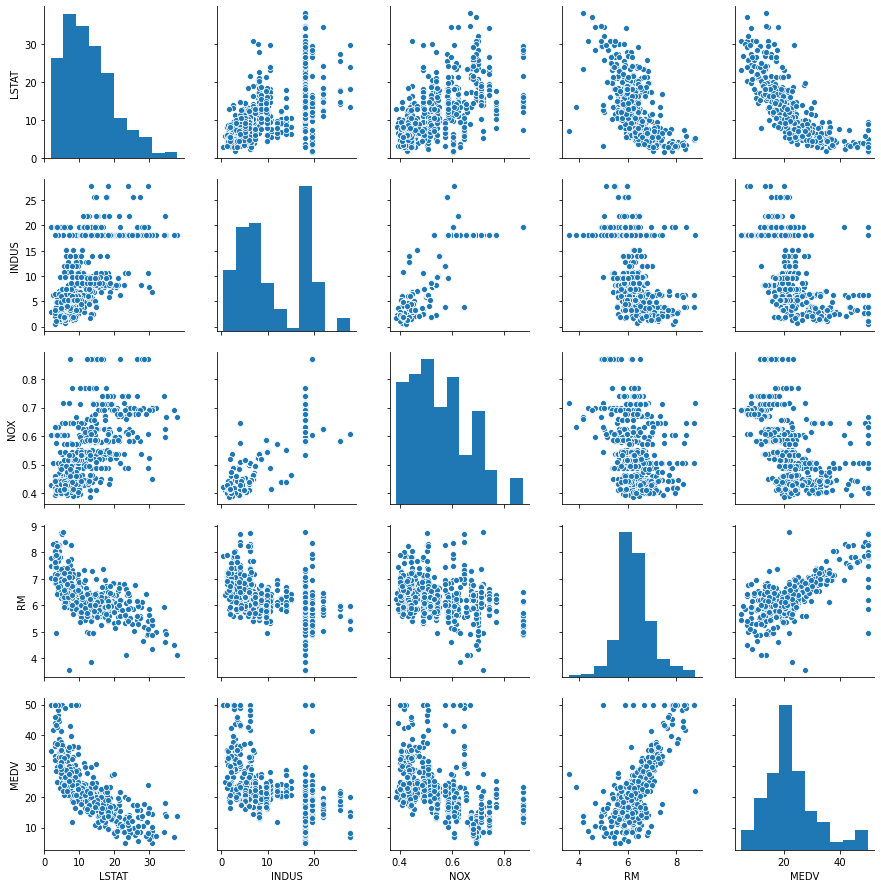

In [5]:
sns.pairplot(data=df_boston[['LSTAT', 'INDUS', 'NOX', 'RM', 'MEDV']])

The 2nd plot below is a heat map showing the <a href=https://en.wikipedia.org/wiki/Pearson_correlation_coefficient>Pearson Correlation Coefficient</a> for the entire dataset. Please note the correlation coefficient can be either a positive and a negative number between 1 to -1 with higher values representing stronger linear relationship.
Final note is that the correlation plots only show pairwise results, meaning if there is relationship between more than 2 variables it is not captured here. The main purpose of the plot below is to identify strongly correlated features and drop them as a part of feature engineering. 

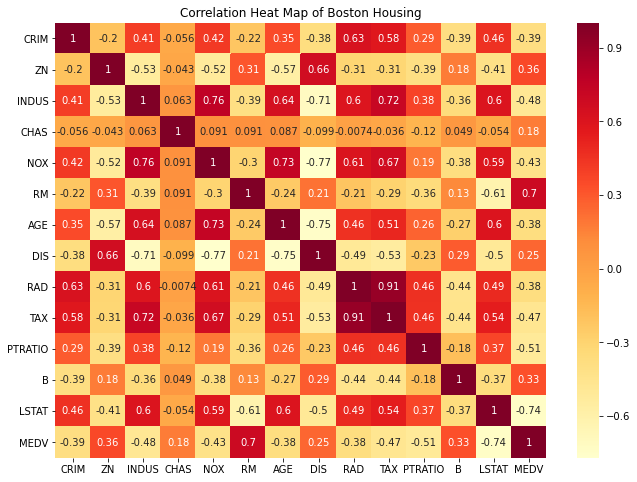

In [6]:
plt.figure(figsize=(11,8))
plt.title("Correlation Heat Map of Boston Housing")
sns.heatmap(df_boston.corr(),annot=True,cmap='YlOrRd')
plt.show()

The pairwise correlation plot can also be plotted a barplot as shown below. In this case the height of the bars represents the strengthen of the correlation of each feature to the single response variable.

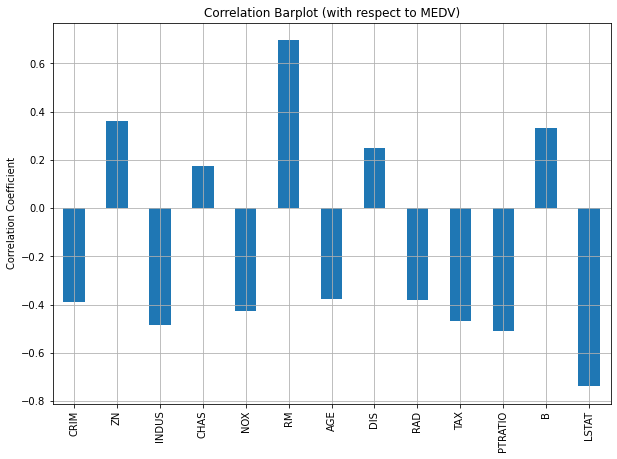

In [7]:
plt.figure(figsize=(10,7))
plt.title('Correlation Barplot (with respect to MEDV)')
plt.ylabel('Correlation Coefficient')
(df_boston.corr()['MEDV'][:-1]).plot(kind='bar')
plt.grid()
plt.show()

## 5. Training & evaluating the implemented neural network

The usual procedure of splitting the data frame into train and test sets are followed. The network construction is shown below. The network consists of a 20 node leakyRELU layer and a 20 node ELU layer. Since there is only one response variable, the final layer has one node and doesn't have any activation function. The summary shows the neural network architecture in detail.

In [10]:
X_train,X_test,y_train,y_test = train_test_split(X,y,test_size=0.3,random_state=42)

In [11]:
nn2 = dense_NN_sgd_reg()
nn2.input_data(X_train,y_train)
#nn2.add_layer(nodes=20,act_fun='tanh')
nn2.add_layer(nodes=15,act_fun='elu')
nn2.add_layer(nodes=5,act_fun='elu')
#nn2.add_layer(nodes=5,act_fun='elu')
nn2.add_layer(nodes=1,act_fun=None)
nn2.nn_compile()
nn2.summary()

Layer: 1  Node Count: 15  Activation Function: elu
Layer: 2  Node Count: 5  Activation Function: elu
Layer: 3  Node Count: 1  Activation Function: None
Total Number of Trainable params: 296


In [12]:
nn2.fit(alpha=0.8,epochs=20000,batch_size=10,call_back=5000,verbose=False)

Text(0.5, 1.0, 'Cost = 0.785')

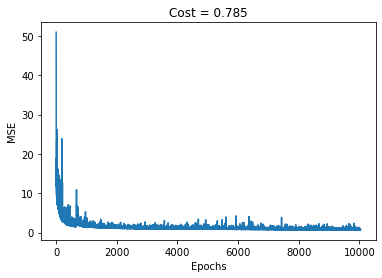

In [13]:
plt.plot(nn2.cost_list)
plt.xlabel('Epochs')
plt.ylabel('MSE')
plt.title('Cost = '+ str(np.round(nn2.cost_list[-1],3)))

R<sup>2</sup> and Explained Variance score can be calculated for the hold out test set as shown below using the scikit learn package. Please refer to this Stack Overflow post to gain better understanding of explained variance score used in scikit-learn. It is metric similar to R<sup>2</sup> Ratio of variance seen in data explained by the model to the overall variance. https://stackoverflow.com/questions/24378176/python-sci-kit-learn-metrics-difference-between-r2-score-and-explained-varian . Higher value closer to 1.0 is better. R,sup>2</sup> = 0.826 shows that over 80% of the variation seen in the data is explained by the model.

In [14]:
from sklearn.metrics import r2_score, explained_variance_score
print("Implemented Neural Network Performance on Test set:")
print('R-sqr = ',np.round(r2_score(y_test,nn2.predict(X_new=X_test)),3))
print('Explained Variance Score =', np.round(explained_variance_score(y_test,nn2.predict(X_new=X_test)),3))

Implemented Neural Network Performance on Test set:
R-sqr =  0.846
Explained Variance Score = 0.847


The implemented neural network predictions are stored in the boston dataset under a new column. The next step is to use other machine learning algorithms to compare the performance. 
Note GridSearchCV or something equivalent could have been used to do hyperparameter tuning and to reduce bias in the training process of the network above. This will be investigated in a different notebook or a future release of this notebook.

In [15]:
df_boston['MEDV_INN'] = nn2.predict(X_new=X)

## 6. Scikit Learn's Multiple Linear Regression, Gradient Boosting & GOF plot

As a part of the evaluation process, 3 other algorithms are used to see if the performance scores can be improved. The first one is the multiple linear regression model from scikit learn

###  Multiple Linear Regression

In [16]:
from sklearn.linear_model import LinearRegression
lin_model = LinearRegression()
lin_model.fit(X_train,y_train)

LinearRegression()

In [17]:
print("MLR Performance on Test set:")
print('R-sqr = ',np.round(r2_score(y_test,lin_model.predict(X=X_test)),3))
print('Explained Variance Score =', np.round(explained_variance_score(y_test,lin_model.predict(X=X_test)),3))

MLR Performance on Test set:
R-sqr =  0.711
Explained Variance Score = 0.711


In [18]:
df_boston['MLR_MEDV']=lin_model.predict(X)

### Gradient Boosting Regression

Gradient boosting is one of the best performing tree based machine learning models and scikit learn's gb regressor is trained on the boston data set. Please refer to the wikipedia page for more info https://en.wikipedia.org/wiki/Gradient_boosting#:~:text=Gradient%20boosting%20is%20a%20machine,prediction%20models%2C%20typically%20decision%20trees. The scikit-learn webpage gives more details about the GB regressor class. https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.GradientBoostingRegressor.html

In [19]:
from sklearn.ensemble import GradientBoostingRegressor

gb_model = GradientBoostingRegressor(random_state=42,learning_rate=0.1,n_estimators=1000)

gb_model.fit(X_train,y_train)

GradientBoostingRegressor(n_estimators=1000, random_state=42)

In [20]:
print("GB Performance on Test set:")
print('R-sqr = ',np.round(r2_score(y_test,gb_model.predict(X=X_test)),3))
print('Explained Variance Score =', np.round(explained_variance_score(y_test,gb_model.predict(X=X_test)),3))

GB Performance on Test set:
R-sqr =  0.895
Explained Variance Score = 0.895


In [21]:
df_boston['gb_MEDV']=gb_model.predict(X=X)

Among the 3 algorithms Gradient Boosting performs the best. Now it is possible to do a grid search to tune the hyperparameters in btoh the neural network implementation and the GB to improve its performance on the test scores even further.

### Goodness of Fit

The all results can be summarized in a Goodness of Fit plot with the predictions on the X axis and actual Median home values on the Y axis.

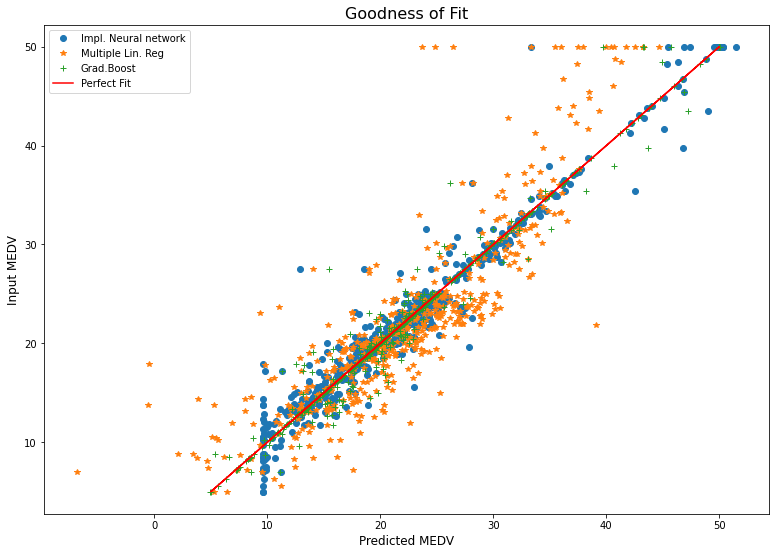

In [22]:
plt.figure(figsize=(13,9))
plt.plot(df_boston['MEDV_INN'],df_boston['MEDV'],'o',label="Impl. Neural network")
plt.plot(df_boston['MLR_MEDV'],df_boston['MEDV'],'*',label="Multiple Lin. Reg")
plt.plot(df_boston['gb_MEDV'],df_boston['MEDV'],'+',label="Grad.Boost")
plt.plot(df_boston['MEDV'],df_boston['MEDV'],color='red',label='Perfect Fit')
plt.xlabel("Predicted MEDV",size=12)
plt.ylabel('Input MEDV',size=12)
plt.title('Goodness of Fit',size=16)
plt.legend()
plt.show()